In [1]:
# KPMG Forecasting Project
# Ensemble Technique
# Author: Kushal Wijesundara

In [2]:
import numpy as np
import pandas as pd
import datetime 
from functools import reduce
import matplotlib.pyplot as plt
date = '2003-09-01'
window = 72

### Load short-term data

In [3]:
ST01 = pd.read_csv('one_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST02 = pd.read_csv('two_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST03 = pd.read_csv('three_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST04 = pd.read_csv('four_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST05 = pd.read_csv('five_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST06 = pd.read_csv('six_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST07 = pd.read_csv('seven_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST08 = pd.read_csv('eight_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST09 = pd.read_csv('nine_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST10 = pd.read_csv('ten_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST11 = pd.read_csv('eleven_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]
ST12 = pd.read_csv('twelve_month_prediction.csv').iloc[:,1:].set_index('ds')[date:]

### Load long-term data for sector models

In [4]:
LTsec = pd.read_csv('LTsec.csv').set_index('date')

### Define ensemble model generators

In [5]:
# n=1: only ST Model effect
def generate_Ensemble(ST,t,n):
  ST.index = pd.to_datetime(ST.index)
  ST = ST.iloc[t::18, :]
  ST = ST.rename(columns={'ds': 'date','yhat': 'ST_EPS_10YR_pred', 'y': 'EPS_10YR'})
  Ensemble = ST.assign(Ensemble_pred=lambda x: ST['ST_EPS_10YR_pred']*n)
  Ensemble = Ensemble[['EPS_10YR','Ensemble_pred']]
  return Ensemble

In [6]:
EN01 = generate_Ensemble(ST01,0,1)
EN02 = generate_Ensemble(ST02,1,1)
EN03 = generate_Ensemble(ST03,2,1)
EN04 = generate_Ensemble(ST04,3,1)
EN05 = generate_Ensemble(ST05,4,1)
EN06 = generate_Ensemble(ST05,5,1)

In [7]:
# n>0.5: more ST Model effect
# n<0.5: more lT Model effect
def generate_Ensemble(ST, LT, t, n):
  ST.index = pd.to_datetime(ST.index)
  LT.index = pd.to_datetime(LT.index)
  STLT = pd.concat([ST, LT], axis=1)
  STLT = STLT.iloc[t::18, :]
  STLT = STLT.rename(columns={'yhat': 'ST_EPS_10YR_pred', 'EPS_10YR_pred': 'LT_EPS_10YR_pred'})
  Ensemble = STLT.assign(Ensemble_pred=lambda x: STLT['ST_EPS_10YR_pred']*(n) +  STLT['LT_EPS_10YR_pred']*(1-n))
  Ensemble = Ensemble[['EPS_10YR','Ensemble_pred']].dropna()
  return Ensemble

In [8]:
# systematically change n (0 < n < 1) to minimize error metric and observe forecast plot
EN07 = generate_Ensemble(ST07, LTsec, 6, 0.6)
EN08 = generate_Ensemble(ST08, LTsec, 7, 0.5)
EN09 = generate_Ensemble(ST09, LTsec, 8, 0.5)
EN10 = generate_Ensemble(ST10, LTsec, 9, 0.4)
EN11 = generate_Ensemble(ST11, LTsec, 10, 0.3)
EN12 = generate_Ensemble(ST12, LTsec, 11, 0.1)

In [9]:
# n=1: only lT Model effect
def generate_Ensemble(LT, t, n):
  LT.index = pd.to_datetime(LT.index)
  LT = LT.iloc[t::18, :]
  LT = LT.rename(columns={'EPS_10YR_pred': 'LT_EPS_10YR_pred'})
  Ensemble = LT.assign(Ensemble_pred=lambda x: LT['LT_EPS_10YR_pred']*n)
  Ensemble = Ensemble[['EPS_10YR','Ensemble_pred']]
  return Ensemble

In [10]:
EN13 = generate_Ensemble(LTsec,12,1)
EN14 = generate_Ensemble(LTsec,13,1)
EN15 = generate_Ensemble(LTsec,14,1)
EN16 = generate_Ensemble(LTsec,15,1)
EN17 = generate_Ensemble(LTsec,16,1)
EN18 = generate_Ensemble(LTsec,17,1)

### Combine weighted data and generate overall ensemble result

In [11]:
EN = pd.concat([EN01,EN02,EN03,EN04,EN05,EN06,EN07,EN08,EN09,EN10,EN11,EN12,EN13,EN14,EN15,EN16,EN17,EN18]).reset_index()
Ensemble = EN.rename(columns={'index': 'date'}).sort_values(by='date').set_index('date').loc[date:]

In [12]:
# Error metric
Ensemble['MAPE'] = ((Ensemble.EPS_10YR-Ensemble.Ensemble_pred).abs()
                 .div(Ensemble.EPS_10YR)
                 .cumsum()
                 /np.arange(1,len(Ensemble)+1)
             )
Ensemble["MAPE"].abs().mean()

1.882351768464808

In [13]:
Ensemble = Ensemble[["EPS_10YR", "Ensemble_pred"]]
Ensemble.to_csv("Ensemble.csv")

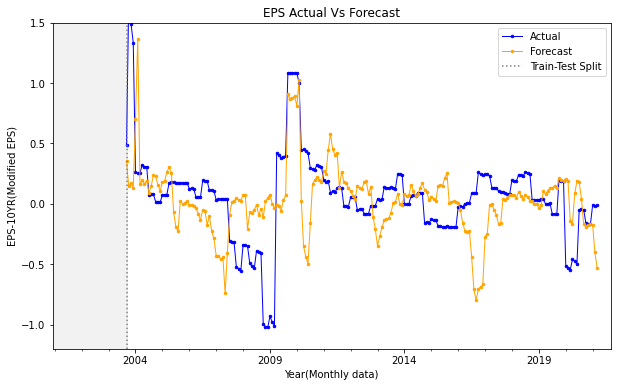

In [14]:
plt.figure(figsize=(10,6))
ax1 = Ensemble.EPS_10YR.plot(color='blue',label='Actual', linestyle="-",marker='o', markersize=2.5, linewidth=1)
ax2 = Ensemble.Ensemble_pred.plot(color='orange', label='Forecast', marker='o', markersize=2.5, linewidth=1)
ax1.set_ylabel('EPS-10YR(Modified EPS)')
ax1.set_xlabel('Year(Monthly data)')
ax1.set_xlim([datetime.date(2000,12,1), datetime.date(2021,9,1)])
ax1.set_ylim([-1.2, 1.5])
plt.title('EPS Actual Vs Forecast')
plt.axvline(pd.Timestamp(date),color="grey", linestyle=":", label = 'Train-Test Split')
plt.axvspan(pd.Timestamp(date), pd.Timestamp(window), alpha=0.1, color='grey')
plt.legend()
plt.show()